In [1]:
%matplotlib inline
import numpy as np
import random
from __future__ import division
import wave, struct, numpy as np, matplotlib.mlab as mlab, pylab as pl
import matplotlib.pyplot as plt
import gc

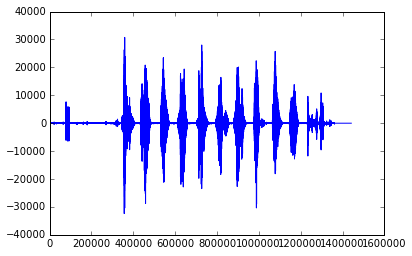

In [2]:
filename = "CML_Recording_Both.wav"
w = wave.open(filename,"rb")

#returns a named tuple (nchannels, sampwidth, framerate, 
# nframes, comptype, compname)
waveParams = w.getparams()

s = w.readframes(waveParams[3])
w.close()
waveArray = np.fromstring(s, np.int16)

pl.figure()
pl.plot(waveArray)

spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256,Fs=waveParams[2],sides='onesided')


In [3]:
# returns bit array of .wav file, and framerate
def get_wave(filename):
    w = wave.open(filename,"rb")
    waveParams = w.getparams()
    s = w.readframes(waveParams[3])
    w.close()
    waveArray = np.fromstring(s, np.int16)
    return waveArray, waveParams[2]

# returns wave array of one track of stereo .wav file
def get_wave_stereo(filename):
    rate, data = wavfile.read(filename)
    # only get speaker values of one side
    data = data[:,0]
    return data, rate

# power spectrogram is the absolute value SQUARED of the stft
def get_spectrogram(stft):
    stft[0,:] = stft[0,:]/2
    return 4*np.square(np.absolute(stft))

# takes in wave file as input
# win_size is the length of the window in samples
# overlap is the amount of overlap between windows in samples
def my_stft(wave, win_size, overlap):
    # power sinbell analysis window
    win = sinebell(win_size, overlap)
    # make the frames
    frames, wave_pad = make_frames(wave, win, overlap)
    # fft, for each column
    stft = np.fft.fft(frames, axis = 0)
    # keep the spectrum associated with the positive frequencies (potentially times to the upper frequencies)
    if len(win)%2 == 0:
        stft = stft[:int(len(win)/2)+1]
    else:
        stft = stft[:int((len(win)+1)/2)]
    return stft, wave_pad
    
# create sinebell window of length win_size, with overlap, DONE
def sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )
    return win

# computes sinebell window with smooth edges, this should be an improvement
def power_sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )**2
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )**2
    return win

# x is the input signal, win is the analysis window, overlap
# returns frame matrix and padded input signal x_pad
def make_frames(x, win, overlap):
    win_len = win.shape[0]
    x_len = len(x)
    
    # number of frames
    num_frames = int(np.ceil((x_len + overlap)/(win_len - overlap)))
    
    # initializing zero padded signal
    pad_len = int(overlap + num_frames * (win_len - overlap))
    x_pad = np.zeros(pad_len)
    x_pad[overlap: overlap + x_len] = x
    
    # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_len - overlap)
    
    # initialize frames matrix
    frames = np.zeros((win_size, num_frames))
    for i in range(num_frames):
        frames[:,i] = (x_pad[frame_ind[i] : frame_ind[i] + win_size] * win)
    
    return frames, x_pad
    
def my_istft(stft, win_size, overlap):
    # power sinbell analysis window
    win = sinebell(win_size, overlap)
    (num_coeff, num_frames) = stft.shape
    
    # recover full stft by conjugate symmetry of the fourier expansion of real signals
    stft_full = np.zeros((win_size, num_frames), dtype = np.complex128)
    stft_full[:num_coeff,:] = stft
    
    # reasoning: stft[ num_coeff - 1] is the both the negative and positive Nyquist frequency if win_size is even
    # thus, we take the conjugate only of stft[ num_coeff - 2:0:-1 ]
    if win_size%2 == 0:
        stft_full[num_coeff:, :] = np.conj(stft[num_coeff-2:0:-1, :])
    else:
        stft_full[num_coeff:,:] = np.conj(stft[num_coeff-1:0:-1, :])
        
    # take inverse fft of recovered stft
    istft = np.fft.ifft(stft_full, axis = 0)
    # reconstruct padded signal by taking overlap into account
    x_pad = overlap_add(istft, win_size, overlap)
    return x_pad

def overlap_add(signal, win_size, overlap):
    
    win = sinebell(win_size, overlap)
    (temp, num_frames) = signal.shape

    if temp != win_size:
        print("Dimensions of ISTFT are wrong!")
    
    pad_len = overlap + num_frames * (win_size - overlap)
    x_pad = np.zeros(pad_len, dtype = np.complex128)
    
     # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_size - overlap)
    
    # do we really need the window again here?
    x_pad[frame_ind[0]:frame_ind[0] + win_size] = signal[:,0] * win
    for i in range(1,num_frames):
        x_pad[frame_ind[i]:frame_ind[i] + win_size] = x_pad[frame_ind[i]:frame_ind[i] + win_size] + signal[:,i] * win
    return x_pad


In [4]:
# OLD OBJECTIVES
'''
def compute_obj(v,W,h,eps):
    whv = (np.dot(W,h) + eps)/(v + eps)
    div = whv - np.log(whv) - 1 
    div = np.array(div)
    #print(div.shape)
    return np.sum( div )

# epsilon divergence gradient
def compute_grad(v,W,h,eps):
    grad = np.dot(W.T, (1/(v + eps) - 1/(np.dot(W,h) + eps)))
    return grad
'''

'\ndef compute_obj(v,W,h,eps):\n    whv = (np.dot(W,h) + eps)/(v + eps)\n    div = whv - np.log(whv) - 1 \n    div = np.array(div)\n    #print(div.shape)\n    return np.sum( div )\n\n# epsilon divergence gradient\ndef compute_grad(v,W,h,eps):\n    grad = np.dot(W.T, (1/(v + eps) - 1/(np.dot(W,h) + eps)))\n    return grad\n'

In [72]:

def compute_obj(v,W,h,eps):
    vhw = (v + eps) / (np.dot(W,h) + eps)
    div = vhw - np.log(vhw) - 1
    return np.sum( div )

def compute_grad(v,W,h,eps):
    (F,K) = W.shape
    grad = np.dot( ( 1 / (np.dot(W,h + eps)) - (v + eps) / (np.square(np.dot(W,h))) + eps).T , W )
    return grad.T

# important! 
# Not only do we need h = h_t but also h_m = h_(t-1) and h_p = h_(t+1)
# lambda is the smoothness constant
def compute_smooth_obj(v,W,h,h_m,h_p,lamb,eps):
    
    h = h.reshape(h.shape[0],1)
    h_m = h_m.reshape(h_m.shape[0],1)
    h_p = h_p.reshape(h_p.shape[0],1)
    
    # compute regular objective
    # maybe doing this direct instead of the function call is faster:
    # whv = (np.dot(W,h) + eps)/(v + eps)
    # div = whv - np.log(whv) - 1 
    div = compute_obj(v,W,h,eps)
    
    # compute smoothness terms with epsilon
    s1 = (h + eps) / (h_m + eps)
    s2 = (h + eps) / (h_p + eps)
    sm = s1 - np.log(s1) - 1
    sm += s2 - np.log(s2) - 1
    # returning properly scaled smooth objective
    return div + lamb * np.sum( sm )
    
# input parameters as above
def compute_smooth_grad(v,W,h,h_m,h_p,lamb,eps):

    # the famous reshape trio
    h = h.reshape(h.shape[0],1)
    h_m = h_m.reshape(h_m.shape[0],1)
    h_p = h_p.reshape(h_p.shape[0],1)

    # calculates gradient of regular divergence
    div_grad = compute_grad(v,W,h,eps)

    # calculating gradient of smoothness term
    sm_grad = 1 / (h_m + eps) + 1 / (h_p + eps) - 2 / (h + eps)
    sm_grad = sm_grad.reshape(sm_grad.shape[0],1)
    
    # returning properly scaled gradient of smooth objective 
    return div_grad + lamb * sm_grad

In [6]:
def grad_checker(v, W, h):
    eps = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(h.shape)
    for i in range(k):
        ei = np.zeros(h.shape)
        ei[i] = eps
        t_grad[i] = (compute_obj(v,W,h+ei, 1e-12) - compute_obj(v,W,h-ei,1e-12)) / (2*eps)
    print(t_grad)
    print(compute_grad(v,W,h,1e-12))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 1))

[[-1.01869864]
 [-1.34158325]]
[[-1.01869533]
 [-1.34157974]]


In [53]:
# second grad checker for smooth objective functions: Works!
def grad_checker(v,W,H,ind_t,lamb,eps):
    eps_dif = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(H[:,ind_t].shape)
    
    h = H[:,ind_t]
    h_p = H[:, ind_t + 1]
    h_m = H[:, ind_t - 1]
    
    h = h.reshape(h.shape[0],1)
    t_m = h_m.reshape(h_m.shape[0],1)
    h_p = h_p.reshape(h_p.shape[0],1)
    
    for i in range(k):
        ei = np.zeros(h.shape)
        ei[i] = eps_dif
        t_grad[i] = (compute_smooth_obj(v,W,h + ei , h_m, h_p, lamb,eps) - compute_smooth_obj(v,W,h - ei, h_m, h_p, lamb,eps)) / (2*eps_dif)
    print(t_grad)
    print(compute_smooth_grad(v,W,h, h_m, h_p,lamb,eps))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 3),1,100,1e-12)

[ -15.49904713  498.26814724]
[[ -15.49887672]
 [ 498.26884381]]


In [8]:
def gradient_backtracking(v, W, h, max_iter, compute_grad, compute_obj, eps):
    
    v = v.reshape(v.shape[0],1)
    h = h.reshape(h.shape[0],1)

    beta = 0.2 #backstep factor between 0.1 and 0.8
    opt_prec = 1-1e-6 # optimization precision
    eta = 1e-1 #initial step size
    
    #obj = [None]*max_iter
    
    max_backstep = 20 # maximum number of backsteps
    t = 0 # backstepping counter
    k = 0 # gradient step counter 
    
    old_obj = compute_obj(v,W,h,eps)

    while( k < max_iter and t != max_backstep ):
        
        grad = compute_grad(v,W,h,eps)
        #obj[k] = compute_obj(v,W,h,eps)
        
        t = 0 # reset backstepping counter
        eta = 1/beta*eta # try to increase stepsize slightly again
        
        # make sure h-n*grad is positive
        while(any(h - eta * grad < 0)  and t < max_backstep ):
            t += 1
            eta = beta * eta
    
        new_obj = compute_obj(v,W,(h - eta*grad),eps)
        
        while( new_obj > opt_prec * old_obj and t < max_backstep):
            t += 1
            eta = beta * eta
            new_obj = abs(compute_obj(v,W,(h - eta*grad),eps))
                      
        h = h - eta * grad # update h according to gradient step
        k += 1 # update gradient step counter
        old_obj = new_obj
        
    h = h.reshape(h.shape[0],)
    return h

h = gradient_backtracking(np.random.rand(10,1), np.random.rand(10,2),  np.random.rand(2, 1), 100, compute_grad, compute_obj, 1e-12)


In [9]:
#plt.plot([i for i in range(len(obj))], obj)

In [73]:
def online_nmf(spectrum, W, H,A, B, rho, beta, eta, eps):
           
    a = np.zeros(W.shape)
    b = np.zeros(W.shape)
    
    t = 1
    W_old = W + 1.5*eta
    k = W.shape[1]
    h = np.random.rand(W.shape[1],)
    n = spectrum.shape[1]
    cost = []
    cost.append(compute_obj(spectrum,W,H,eps))
    print(cost)
    while np.linalg.norm(W - W_old, ord = "fro") > eta:
        
        t = t+1 
        
        ind = random.randint(0, n-1)
        v = spectrum[:,ind]
    
        h = gradient_backtracking(v, W, H[:,ind], 100, compute_grad, compute_obj, eps)
        
        H[:, ind] = h
       
        h = h.reshape(h.shape[0],1)
        v = v.reshape(v.shape[0],1)
        den = eps + np.dot(W, h)
        
        a += np.dot(((eps+v)/(den)**2), h.T) * np.square(W) 
        
        b += np.dot(1/den, h.T)
       
        if t % beta == 0:
            A = A + rho*a
            a = 0
            B = B + rho*b
            b = 0
            W_old = W
            W = np.sqrt(A/B)
            
            for i in range(k):
                s = np.sum(W[:,i])
                W[:,i] = W[:,i]/s
                A[:,i] = A[:,i]/s
                B[:,i] = B[:,i]*s
                #print(i)

            #print(np.linalg.norm(compute_obj(spectrum,W_old,H,eps))- compute_obj(spectrum,W,H,eps)) 
            gc.disable()
            cost.append(compute_obj(spectrum,W,H,eps))
            gc.enable()
            
        #cost.append(compute_obj(spectrum,W,H,eps))
        if t > 100*n:
            print(" W shape" , W.shape)
            break

        #print("W", np.linalg.norm(W[:,1]))
        #print("H", np.linalg.norm(H[1]))
        #print(compute_obj(spectrum,W,H.T,eps))
        
    print("t" , t)
    print(cost[-1])
    return W, H, cost


In [11]:
np.linalg.norm(spectrum[:,4])

9.9288495889693049

In [74]:
eps = 1e-12
(F,N) = spectrum.shape
K = 10
W = abs(np.random.randn(F,K)) + np.ones((F,K))
H = abs(np.random.randn(K,N)) + np.ones((K, N))

A = np.zeros(W.shape)
B = np.zeros(W.shape)

r = 1
beta = 1000
rho = r**(beta/spectrum.shape[1])

# for profiling:
#import cProfile
#cProfile.run('online_nmf(spectrum, W, H, A, B, rho, beta, 1e-6, eps)')

W, H, cost = online_nmf(spectrum, W, H, A, B, rho, beta, 1e-2, eps)


[25561150.11135016]
('t', 22000)
99963606.8218


In [ ]:
import cProfile
cProfile.run('online_nmf(spectrum, W, H, A, B, rho, beta, 1e-4, eps)')

In [278]:
change = []
for i in range(1, len(cost)):
    change.append(np.linalg.norm(cost[i]-cost[i-1]))

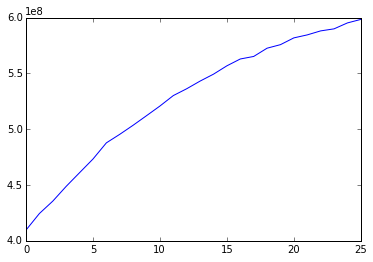

In [70]:
plt.plot([i for i in range(len(cost[5:]))], cost[5:])

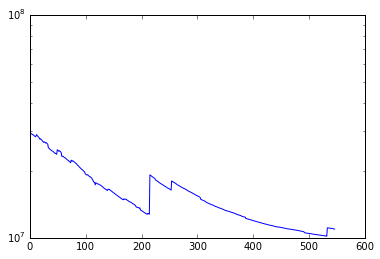

In [53]:
plt.semilogy([i for i in range(len(cost))], cost)

In [141]:
W.shape

(129, 10)

In [142]:
H.shape

(10, 11263)

In [143]:
spectrum.shape

(129, 11263)

In [16]:
def get_closest(x, centers):
    distances = []
    
    #get the distance from the point(x) to every centroid
    #and get the index of centroid that yields 
    #the minimum distance 
    
    for mu in centers:
        distances.append(np.linalg.norm(x-mu))
    index = np.argmin(distances)
    
    return index, min(distances)

def k_means_objective(X, k, C, centers):
    
    sum_distance = 0
    for j in range(k):
        for x in X[C==j]:
            sum_distance += (np.linalg.norm(x-centers[j]))**2
                
    return sum_distance

In [36]:
from sklearn import preprocessing

def mini_batch(X_orig, k, b, max_iter):
    
    X = preprocessing.normalize(X_orig)

    v = [0]*k
    
    #centers = random.sample(X, k)
    
    centers = [0]*k 
    centers[0] = X[random.randint(0, len(X)-1)]
    distortion = []
    
    for r in range(k-1):
        x = random.random()
        num_dx = (get_closest(X[0],centers)[1])**2
        den_dx = 0
        for x_i in X:
            den_dx += (get_closest(x_i,centers)[1])**2
        index = 0
        while num_dx/den_dx < x:
            
            index += 1
            num_dx += (get_closest(X[index],centers)[1])**2

        centers[r+1] = X[index]
    centers = np.array(centers)

   
    for i in range(max_iter):
        M = np.array(random.sample(list(X),b))
        C=[0]*len(M)
        for i,x in enumerate(M): 
            index = get_closest(x, centers)[0]
            C[i] = index
      
        
        for i, x in enumerate(M):
            index = C[i]
            v[index]+=1
            n = 1/v[index]
    
            centers[index] = (1- n)*centers[index] + n*x
        '''
        D=[0]*len(X)
        for i in range(len(X)): 
            index = get_closest(X[i], centers)[0]
            D[i] = index
        
        D = np.array(D)
        
        distortion.append(k_means_objective(X, k, D, centers))
        '''
            
    return centers

In [37]:
centers = mini_batch(spectrum.T, K,100, 1000)
centers = np.array(centers)
print(np.sum(centers[:,0]))
W2 = centers.T

1.52513158312


In [ ]:
import cProfile
cProfile.run('mini_batch(spectrum.T, K, 100, 100)')

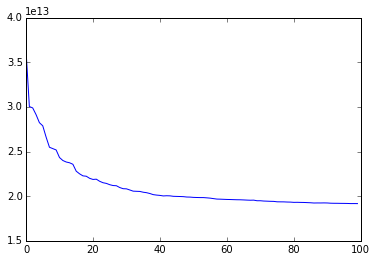

In [238]:
plt.plot([i for i in range(len(distortion))], distortion)

In [34]:
eps = 1e-12
K = 10

r = 1
beta = 100
rho = r**(beta/spectrum.shape[1])

H2 = abs(np.random.randn(K,N)) + np.ones((K, N))
A2 = np.zeros(W.shape)
B2 = np.zeros(W.shape)

W2, H2, cost2 = online_nmf(spectrum, W2, H2, A2, B2, rho, beta, 1e-4, eps)


('t', 59500)
11927868.0308


-1436915.73287


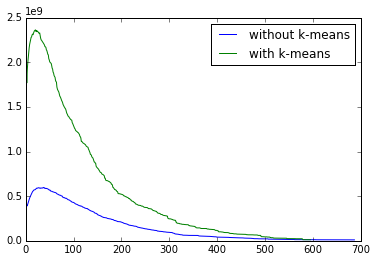

In [35]:
plt.plot([i for i in range(len(cost))], cost, label = "without k-means")
plt.plot([i for i in range(len(cost2))], cost2, label = "with k-means")
plt.legend()
print(cost[-1]-cost2[-1])

In [184]:
compute_obj(spectrum,W2,H2,eps)

27393387.803380556

In [42]:
def gradient_backtracking_smooth(v, W, H, ind, max_iter, compute_smooth_grad, compute_smooth_obj, eps, lamb):

    #TODO: handle edge cases
    h = H[:,ind]
    if ind > 1:
        h_m = H[:,ind-1]
    else:
        h_m = np.zeros((W.shape[1],))
        
    if ind < W.shape[1]-1:
        h_p = H[:,ind+1]
    else:
        h_p = np.zeros((W.shape[1],))
    
    v = v.reshape(v.shape[0],1)
    h = h.reshape(h.shape[0],1)
    h_m = h.reshape(h_m.shape[0],1)
    h_p = h.reshape(h_p.shape[0],1)

    beta = 0.2 #backstep factor between 0.1 and 0.8
    opt_prec = 1-1e-6 # optimization precision
    eta = 1e-1 #initial step size
    
    #obj = [None]*max_iter
    
    max_backstep = 20 # maximum number of backsteps
    t = 0 # backstepping counter
    k = 0 # gradient step counter 

    old_obj = compute_smooth_obj(v,W,h,h_m,h_p,lamb,eps)
    #old_obj = compute_obj(v,W,h,eps)

    while( k < max_iter and t != max_backstep ):
        
        grad = compute_smooth_grad(v,W,h,h_m,h_p,lamb,eps)
        #grad = compute_grad(v,W,h,eps)
        #obj[k] = compute_obj(v,W,h,eps)
        
        t = 0 # reset backstepping counter
        eta = 1/beta*eta # try to increase stepsize slightly again
        
        # make sure h-n*grad is positive
        while(any(h - eta * grad < 0)  and t < max_backstep ):
            t += 1
            eta = beta * eta
    
        new_obj = compute_smooth_obj(v,W,(h - eta*grad),h_m,h_p,lamb,eps)
        
        while( new_obj > opt_prec * old_obj and t < max_backstep):
            t += 1
            eta = beta * eta
            new_obj = abs(compute_obj(v,W,(h - eta*grad),eps))
                      
        h = h - eta * grad # update h according to gradient step
        k += 1 # update gradient step counter
        old_obj = new_obj
        
    h = h.reshape(h.shape[0],)
    return h



In [43]:
#plt.plot([i for i in range(len(obj))], obj)


In [44]:
def online_nmf_smooth(spectrum, W, H,A, B, rho, beta, eta, eps, lamb):

    a = np.zeros(W.shape)
    b = np.zeros(W.shape)
    
    t = 1
    W_old = W + 1.5*eta
    k = W.shape[1]
    h = np.random.rand(W.shape[1],)
    n = spectrum.shape[1]
    cost = []
    cost.append(compute_obj(spectrum,W,H,eps))
    
    while np.linalg.norm(W - W_old, ord = "fro") > eta:
        
        t = t+1 
        
        ind = random.randint(0, n-1)
        v = spectrum[:,ind]
    
        h = gradient_backtracking_smooth(v, W, H,ind, 100, compute_smooth_grad, compute_smooth_obj, eps, lamb)
        
        H[:, ind] = h
       
        h = h.reshape(h.shape[0],1)
        v = v.reshape(v.shape[0],1)
        den = eps + np.dot(W, h)
        
        a += np.dot(((eps+v)/(den)**2), h.T) * np.square(W) 
        
        b += np.dot(1/den, h.T)
       
        if t % beta == 0:
            A = A + rho*a
            a = 0
            B = B + rho*b
            b = 0
            W_old = W
            W = np.sqrt(A/B)
            
            for i in range(k):
                s = np.sum(W[:,i])
                W[:,i] = W[:,i]/s
                A[:,i] = A[:,i]/s
                B[:,i] = B[:,i]*s
                #print(i)

            #print(np.linalg.norm(compute_obj(spectrum,W_old,H,eps))- compute_obj(spectrum,W,H,eps)) 
            gc.disable()
            cost.append(compute_obj(spectrum,W,H,eps))
            gc.enable()
            
        #cost.append(compute_obj(spectrum,W,H,eps))
        if t > 100*n:
            print(" W shape" , W.shape)
            break

        #print("W", np.linalg.norm(W[:,1]))
        #print("H", np.linalg.norm(H[1]))
        #print(compute_obj(spectrum,W,H.T,eps))
        
    print("t" , t)
    print(cost[-1])
    return W, H, cost



In [66]:

W3 = abs(np.random.randn(spectrum.shape[0],K) + np.ones((spectrum.shape[0],K)))
H3 = abs(np.random.randn(K,N)) + np.ones((K, N))
#abs(np.random.randn(K, spectrum.shape[1]) + np.ones((K, spectrum.shape[1])))

A3 = np.zeros(W.shape)
B3 = np.zeros(W.shape)

W3, H3, cost3 = online_nmf_smooth(spectrum, W3, H3, A3, B3, rho, beta, 1e-2, eps, 10**9 )

('t', 22000)
124891311.754


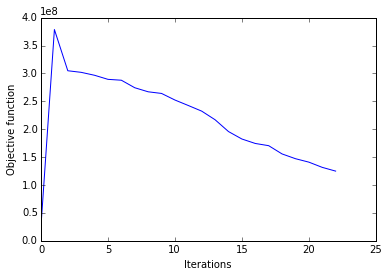

In [67]:
plt.plot([i for i in range(len(cost3))], cost3)

plt.xlabel("Iterations")
plt.ylabel("Objective function")

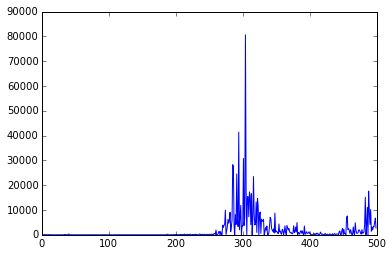

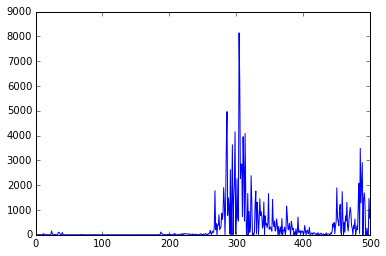

In [77]:
index = random.randint(0, len(H3)-1)
ilist = [i for i in range(500)]
plt.plot(ilist,H[index][2500:3000])
plt.figure()
plt.plot(ilist, H3[index][2500:3000])


In [47]:
lambdas = [10*i for i in range(3,7)]
col_H = [0]*len(lambdas)
obj6= [0]*len(lambdas)
r = 1
K = 10
beta = 1000
rho = r**(beta/spectrum.shape[1])
for l in range(len(lambdas)):
    W6 = abs(np.random.randn(spectrum.shape[0],K) + np.ones((spectrum.shape[0],K)))
    H6 = abs(np.random.randn(K,N)) + np.ones((K, N))
    #abs(np.random.randn(K, spectrum.shape[1]) + np.ones((K, spectrum.shape[1])))

    A6 = np.zeros(W6.shape)
    B6 = np.zeros(W6.shape)

    W6, H6, cost6 = online_nmf_smooth(spectrum, W6, H6, A6, B6, rho, beta, 1e-2, eps, lambdas[l])
    col_H[l] = H6[7]
    obj6[l] = cost6[-1]

('t', 23000)
89014378.537
('t', 22000)
127606066.048
('t', 25000)
63207154.2174


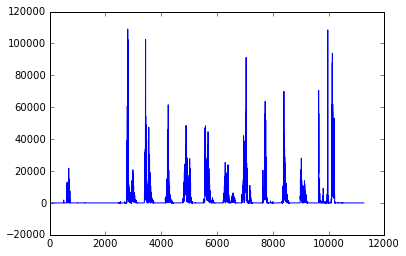

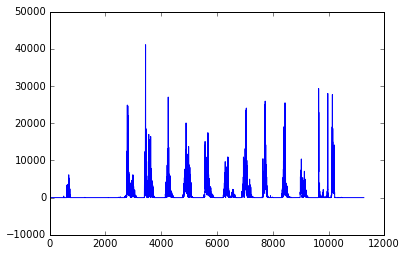

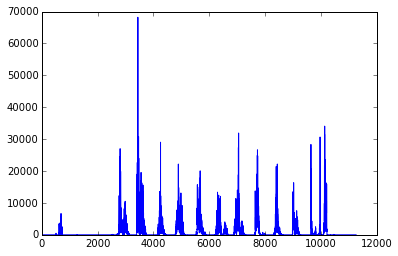

In [51]:
ilist2 = [i for i in range(len(col_H[0]))]
for i in range(len(col_H)):
    plt.plot(ilist2,H[i])
    plt.figure()

In [129]:
import time
eps = 1e-12
K = 10
r = 1
beta = 100
rho = r**(beta/spectrum.shape[1])
ilist1 = [2**i for i in range(6,12)]
    
timelist = [0]*len(ilist1)
obj4 = [0]*len(ilist1)


for ind in range(len(ilist1)):
    
    W4 = abs(np.random.randn(F,K)) + np.ones((F,K))
    H4 = abs(np.random.randn(K,N)) + np.ones((K, N))
    A4 = np.zeros(W4.shape)
    B4 = np.zeros(W.shape)
    start = time.time()
    W4, H4, cost4 = online_nmf(spectrum, W4, H4, A4, B4, rho, ilist1[ind], 1e-4, eps)
    end = time.time()
    timelist[ind] = end-start
    obj4[ind] = cost4[-1]
    
    


('t', 30400)
72110200.1123
('t', 78848)
4757132.72682
('t', 162304)
4206056.54135
('t', 401920)
4155775.18063
('t', 748544)
4266063.41381
(' W shape', (129, 10))
('t', 1126301)
4382569.29268


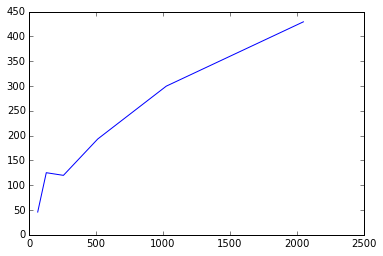

In [130]:
plt.plot(ilist1, timelist)

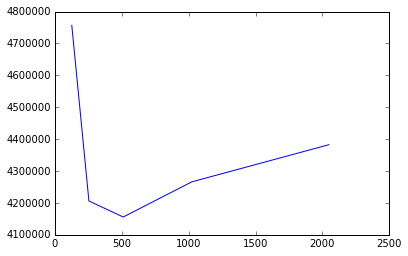

In [132]:
plt.plot(ilist1[1:], obj4[1:])

In [133]:
eps = 1e-12
K = 10
r = 1

obj5 = [0]*len(ilist1)

for ind in range(len(ilist1)):    
    W5 = abs(np.random.randn(F,K)) + np.ones((F,K))
    H5 = abs(np.random.randn(K,N)) + np.ones((K, N))
    A5 = np.zeros(W5.shape)
    B5 = np.zeros(W5.shape)

    beta = ilist1[ind]
    rho = r**(beta/spectrum.shape[1])
    W5, H5, cost5 = online_nmf(spectrum, W5, H5, A5, B5, rho, beta, 1e-4, eps)

    obj5[ind] = cost5[-1]
    
    


('t', 40256)
44745126.6761
('t', 86272)
4499837.80332
('t', 141568)
4072307.20841
('t', 350720)
4138947.39666
('t', 684032)
3905097.90514
(' W shape', (129, 10))
('t', 1126301)
4249734.54038


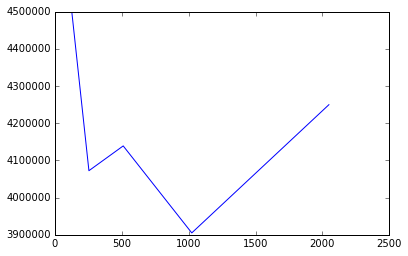

In [135]:
plt.plot(ilist1[1:], obj5[1:])